In [10]:
%matplotlib inline
from IPython.display import Image
import matplotlib

## Generate DAG and test out PCalg

![Dag](img/dag-pearl.png)

In [36]:
import numpy as np 
import pandas as pd
SAMPLE_SIZE = 100000

z1 = np.random.normal(0, 1, SAMPLE_SIZE) #0
z2 = np.random.uniform(0, 1, SAMPLE_SIZE) #1
z3 = z1*z2 + np.random.normal(0, 1, SAMPLE_SIZE) #2

w1 = z1 + np.random.normal(0, 1, SAMPLE_SIZE) #3
w2 = 3 ** z2 + np.random.standard_cauchy(SAMPLE_SIZE) #4

x = w1 * z3 + np.random.lognormal(0, 1, SAMPLE_SIZE) #6
w3 = x + x**3 + np.random.normal(0, 1, SAMPLE_SIZE) #5
y = w3 * z3 + w2 + np.random.normal(0, 1, SAMPLE_SIZE) #7


features = ['z1', 'z2', 'z3',
       'w1', 'w2', 'w3',
        'x', 'y']

data = np.stack([z1,z2,z3,w1,w2,w3,x,y], axis=1)

In [32]:
#FCIT(x, y, Z=np.array())
x = data[:,0].reshape(SAMPLE_SIZE, 1)
y = data[:,1].reshape(SAMPLE_SIZE, 1)
z = data[:,2].reshape(SAMPLE_SIZE, 1)
#z = data[:,()]


In [33]:
l = [FCIT(x,y,z) for i in range(10)]


# Utils

In [13]:
import numpy as np
import functools

def check_dataset(dataset):
    assert isinstance(dataset, np.ndarray),(
        'Dataset must be a 2D numpy array')
    assert dataset.shape[1] >= 2,(
        'Need at leat 2 variables: shape is {}'.format(dataset.shape))
    return dataset
    

def get_features(dataset, feature_names=None):
    if feature_names:
        len_condition = len(feature_names) == dataset.shape[1]
        assert isinstance(feature_names, list) and len_condition,\
            "number of elements in feature_names\
        and number of features in dataset do not match"
        return {k: v for k, v in enumerate(feature_names)}

    return {k: v for k, v in enumerate(range(dataset.shape[1]))}


def trackcalls(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        wrapper.has_been_called = True
        return func(*args, **kwargs)
    wrapper.has_been_called = False
    return wrapper


# PCAlg

In [48]:
import numpy as np
#from .utils import check_dataset, get_features, trackcalls
import networkx as nx
from itertools import combinations, permutations
from collections import defaultdict


class pcalg():
    """
    Peter Spirtes and Clark Glymour ALGorithm

    input :
    dataset =  N*M numpy array where N=sample
            size and M=feature size

    feature_names = dictionary where key = column
                    position, value = column name.
                    if no feature_names provided,
                    key=value=column position


    """
    def __init__(self, dataset, feature_names=None):
        #self.dataset = check_dataset(dataset)
        self.dataset = dataset
        self.features = get_features(dataset,
                                     feature_names)
        self.G = nx.Graph()

    def _instantiate_fully_connected_graph(self):
        self.G.add_nodes_from(self.features.keys())
        for x, y in combinations(self.features.keys(), 2):
            self.G.add_edge(x, y)

    #@trackcalls
    def identify_skeleton(self, indep_test, alpha=0.05,
                          stable=False):
        """
        STEP 1 of PC algorighm
        estimate skeleton graph from the data.
        input :
        indep_test = independence function

        alpha = significance level for independence test

        stable = use the SGS variant of the PC algorithm
                default = false

        """
        self._instantiate_fully_connected_graph()

        self.d_separators = {}
        self.stable = stable
        level = 0
        cont = True

        while cont:
            print("Level order: {}".format(level))
            cont = False
            # in the stable version,
            # only update neighbors at each level
            for x, y in permutations(self.features.keys(), 2):
                if not stable:
                    # in the original version, update neighbors within
                    # each level
                    x_neighbors = list(self.G.neighbors(x))
                if y not in x_neighbors:
                    continue
                x_neighbors.remove(y)
                if len(x_neighbors) >= level:
                    cont = True
                    for z in combinations(x_neighbors, level):
                        pvalue = indep_test(self.dataset[:,x].reshape(self.dataset.shape[0], 1),
                                            self.dataset[:,y].reshape(self.dataset.shape[0], 1),
                                            self.dataset[:,z].reshape(self.dataset.shape[0], len(z))
                                           )
                        print("""Independence test between {} and {} conditioned on {}: {}""".format(
                           self.features[x],self.features[y],[self.features[f] for f in z], pvalue))
                        if pvalue >= alpha:
                            print('Removed')
                            #print("""Remove edge between node {} and node {}, conditioned on {}. pvalue: {}""".format(
                            #self.features[x],self.features[y],[self.features[f] for f in z], pvalue))
                            self.G.remove_edge(x, y)
                            self.d_separators[(x, y)] = z
                            self.d_separators[(y, x)] = z
                            break
                        
            level += 1

    def orient_graph(self, indep_test, alpha):
        """
        STEP 2 of the PC algorithm: edge orientation
        """
        self.G = self.G.to_directed()

        # STEP 1: IDENTIFYING UNSHIELDED COLLIDERS
        # for each X and Y, only connected through
        # a third variable (e.g. Z in X--Z--Y), test idenpendence
        # between X and Y conditioned upon Z.
        # If conditionally dependent, Z is an unshielded collider.
        # Orient edges to point into Z (X->Z<-Y)
        # Testing for conditional independence is not required when using
        # the stable version of the PCALG(i.e. the SGS variant) because
        # we already have all d-separators of order level 1 between X and Y
        self.colliders = {}
        for x, y in combinations(self.features.keys(), 2):
            x_successors = self.G.successors(x)
            if y in x_successors:
                continue
            y_successors = self.G.successors(y)
            if x in y_successors:
                continue
            intersect = set(x_successors).intersection(set(y_successors))
            for z in intersect:
                if z in self.d_separators[(x, y)]:
                    continue
                if not self.stable:
                    pvalue = indep_test(self.dataset[x],
                                        self.dataset[y], self.dataset[z])
                    if pvalue <= alpha:
                        # x and y are conditionnaly dependent
                        # so z is a collider.
                        self.G.remove_edge(z, x)
                        self.G.remove_edge(z, y)
                        continue
                else:
                    self.G.remove_edge(z, x)
                    self.G.remove_edge(z, y)

        # STEP 2: PREVENT SPURIOUS UNSHIELDED COLLIDERS
        # for each X Y Z such that
        # X->Z--Y
        # and where X and Y are not directly connected,
        # orient the ZY edge to point into Y:
        # X->Z->Y
        # if  X->Z<-Y were true, Z would have been picked up
        # as unshielded collider in STEP 1


        #  STEP 3: PREVENT CYCLES
        # If there is a pair of variables, X and Y connected 
        # both by an undirected edge and by a directed path,
        # starting at X, through one or more other variables to Y,
        # orient the undirected edge as X->Y

    def render_graph(self):
        render = nx.draw_networkx(G=self.G, labels=self.features)
        return render

    def save_class(self):
        return


## Independence Tests


In [29]:
import scipy
import scipy.stats
from fcit import fcit

def resit(X, Y, Z, sklearn_model):
    """
    Independently model X and Y as a
    function of Z using models that follow
    the sklearn fit and predict api.

    Predict both X and Y and retrieve residuals.

    Run unconditional independence test between
    the residuals from the X model and the
    residuals from the Y model.

    http://jmlr.org/papers/volume15/peters14a/peters14a.pdf
    """
    
    if Z.shape[1] == 0:
        # unconditional independence test
        model_X = sklearn_model
        model_x = model_X.fit(Z, X)
        return scipy.stats.ttest_ind(X, Y).pvalue
        
    else:
        model_X = sklearn_model
        model_X.fit(Z, X)
        X_hat = model_X.predict(Z)
        model_Y = sklearn_model
        model_X.fit(Z, X)
        model_Y.fit(Z, Y)
        Y_hat = model_Y.predict(Z)
        X_res = X_hat - X
        Y_res = Y_hat - Y
        
        return scipy.stats.ttest_ind(X_res, Y_res).pvalue
    
    
def FCIT(X, Y, Z):
    if Z.shape[1] == 0:
        # unconditional independence test
        return fcit.test(X, Y)
    else:
        return fcit.test(X, Y, Z)
        
        


## Sandbox

In [49]:
from sklearn.tree import DecisionTreeRegressor
pc = pcalg(data, features)
#pc._instantiate_fully_connected_graph()
#pc.render_graph()
if __name__ == '__main__':
    pc.identify_skeleton(indep_test=FCIT, alpha=0.8)

Level order: 0
Independence test between z1 and z2 conditioned on []: 0.9726919497172535
Removed
Independence test between z1 and z3 conditioned on []: 2.917936177841493e-11
Independence test between z1 and w1 conditioned on []: 1.2509718995051971e-12
Independence test between z1 and w2 conditioned on []: 0.9915497621297412
Removed
Independence test between z1 and w3 conditioned on []: 0.16054393979556633
Independence test between z1 and x conditioned on []: 1.3065767692253771e-08
Independence test between z1 and y conditioned on []: 0.001913843134644835
Independence test between z2 and z3 conditioned on []: 0.892443565385828
Removed
Independence test between z2 and w1 conditioned on []: 0.879525461643998
Removed
Independence test between z2 and w2 conditioned on []: 0.9351208747490438
Removed
Independence test between z2 and w3 conditioned on []: 0.8316517949527542
Removed
Independence test between z2 and x conditioned on []: 2.0731662846527117e-06
Independence test between z2 and y c

![Dag](img/dag-pearl.png)

In [50]:
import numpy as np
from fcit import fcit

# Generate some data such that x is indpendent of y given z.
n_samples = 1000
z = np.random.dirichlet(alpha=np.ones(2), size=n_samples)
x = np.vstack([np.random.multinomial(20, p) for p in z]).astype(float)
y = np.vstack([np.random.multinomial(20, p) for p in z]).astype(float)

x


array([[  8.,  12.],
       [  9.,  11.],
       [ 11.,   9.],
       ..., 
       [  7.,  13.],
       [  0.,  20.],
       [  9.,  11.]])

In [ ]:
fcit.

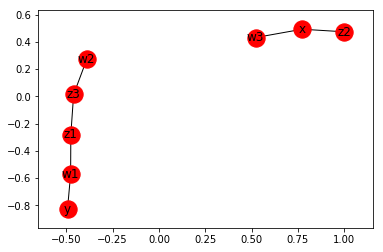

In [50]:
pc.render_graph()

In [1]:
import numpy as np
from fcit import fcit

x = np.random.rand(1000, 1)
y = np.random.randn(1000, 1)

pval_i = fcit.test(x, y) # p-value should be uniform on [0, 1].
pval_d = fcit.test(x, x + y) # p-value should be very small.

In [7]:
pval_i = fcit.test(x, y) # p-value should be uniform on [0, 1].
pval_d = fcit.test(x, x + y) # p-value should be very small.